In [1]:
%pylab inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
Vendor:  Continuum Analytics, Inc.


Populating the interactive namespace from numpy and matplotlib


Package: mkl
Message: trial mode expires in 30 days


In [2]:
import numpy as np
import pandas

# Problem 1

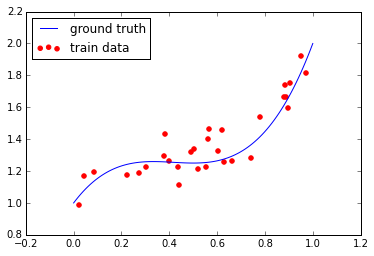

In [6]:
def poly_fun(X, Theta):
    """Compute the value of polynomial with coefficients Theta for points in X"""
    #
    # TODO: Write body of the function.
    # Return a vector of values in points from X (the same shape as X).
    # 
    X_powers = vstack([X**p for p in range(Theta.size)]).T
    Y = X_powers.dot(Theta)
    return Y

#
# The true polynomial relation:
# y(x) = 1 + 2x -5x^2 + 4x^3
#
# TODO: write down the proper coefficients
#
true_poly = array([1., 2., -5., 4.])

def make_dataset(N, theta=true_poly, sigma=0.1):
    """ Sample a dataset """
    #
    # TODO: Sample the dataset using the procedure described in the task.
    #       X and Y should be of shape (N,).
    X = random.uniform(0., 1., N)
    true_Y = poly_fun(X, true_poly)
    Y = array([random.normal(y, sigma) for y in true_Y])
    return X,Y


train_data = make_dataset(30)
XX = np.linspace(0,1,100)
YY = poly_fun(XX, true_poly)
scatter(train_data[0], train_data[1], label='train data', color='r')
plot(XX, poly_fun(XX, true_poly), label='ground truth')
legend(loc='upper left')

In [104]:
#please note: lambda is a reserved keyword in python, thus we use _lambda
def poly_fit(data, degree, _lambda):
    "Fit a polynomial of a given degree and weight decay parameter C"
    powers = np.arange(degree + 1.0).reshape(-1,1)
    X = data[0].reshape(1,-1)
    Y = data[1].reshape(1,-1)
    XX = X**powers
    #
    # TODO: implement the closed-form solution for Theta
    #
    # Please note that np.inv may be numerically unstable.
    # It is better to use np.linalg.solve or even a QR decomposition.
    # Theta = (Y.dot(XX.T) + (Y.size)*_lambda).dot(inv(XX.dot(XX.T)))
    A = XX.dot(XX.T)
    B = (Y.dot(XX.T) +  _lambda).reshape((A.shape[0],))
    # B = (Y.dot(XX.T) + Y.size * _lambda).reshape((A.shape[0],))
    Theta = linalg.solve(A, B)
    return Theta

In [105]:
dataset = make_dataset(10)
degree = 5
T = poly_fit(dataset, degree, 0.)
X,Y = dataset[0], dataset[1]
XX = X**(np.arange(degree + 1.0).reshape(-1,1))
print T.shape, XX.shape, Y.shape
((T.dot(XX) - Y)**2).sum()

(6,) (6, 10) (10,)


0.051419263024027551

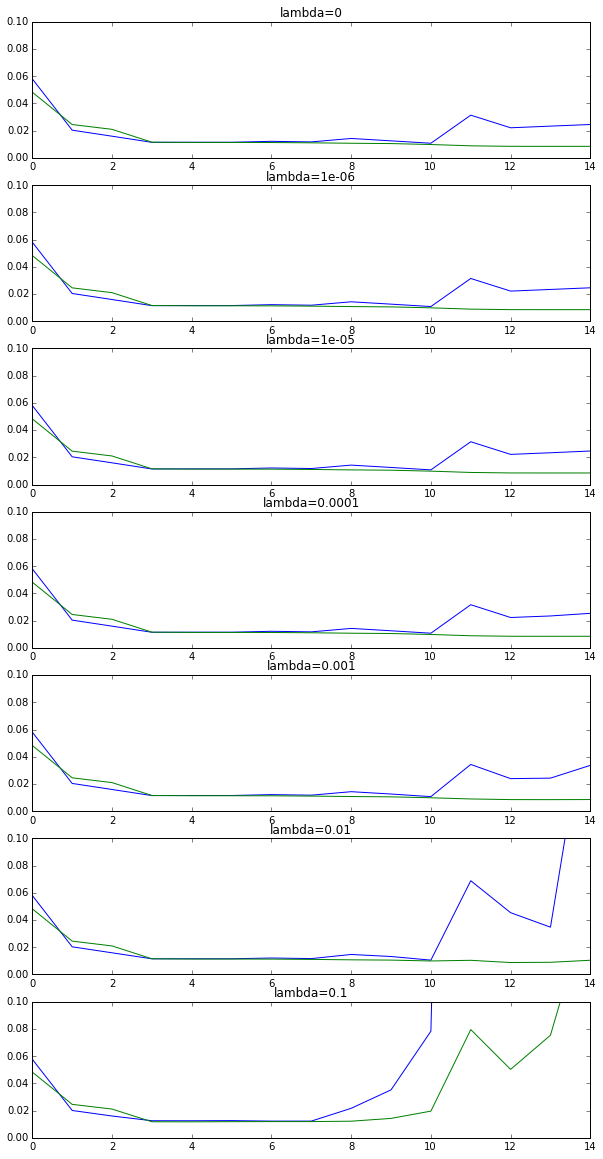

In [113]:
lambdas = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
degrees  = arange(15)

num_repetitions = 30
num_samples = 30

train_errors = np.zeros((len(lambdas), len(degrees)))
test_errors = np.zeros((len(lambdas), len(degrees)))

#sample a single dataset for all experiments
test_data = make_dataset(num_samples)

for repetition in xrange(num_repetitions):
    #sample a new training dataset for this repetition
    train_data = make_dataset(num_samples)
    #scatter(data[0], data[1])
    for degree_i, degree in enumerate(degrees):
        for lambda_i, _lambda in enumerate(lambdas):
            Theta = poly_fit(train_data, degree, _lambda)
            #
            # TODO: compute the mean training and test errors
            #
            XX = test_data[0]**(np.arange(degree + 1.0).reshape(-1,1))
            Y = test_data[1]
            train_errors[lambda_i][degree_i] = ((Theta.dot(XX) - Y)**2).sum()
            XX = train_data[0]**(np.arange(degree + 1.0).reshape(-1,1))
            Y = train_data[1]
            test_errors[lambda_i][degree_i] = ((Theta.dot(XX) - Y)**2).sum()
train_errors /=  num_repetitions
test_errors /= num_repetitions

figure(figsize=(10,20))
for lambda_i, _lambda in enumerate(lambdas):
    subplot(len(lambdas), 1, lambda_i+1)
    plot(degrees, train_errors[lambda_i,:], label='train')
    plot(degrees, test_errors[lambda_i,:],  label='test')
    ylim(0,0.1)
    title('lambda=%g'%(_lambda,))

In [114]:
# SVM Problems

In [6]:
import cvxopt
from sklearn.svm import SVC #support vector for classification


## Problem 2

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


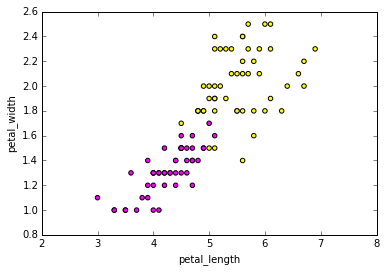

In [3]:
# load iris, extract petal_length and petal_width of versicolors and virginicas

from sklearn import datasets
iris = datasets.load_iris()
print 'Features: ', iris.feature_names
print 'Targets: ', iris.target_names
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

IrisX = np.array(iris.data.T)
IrisX = IrisX[:, iris.target!=0]

IrisX2F = np.vstack([petal_length, petal_width])
IrisX2F = IrisX2F[:, iris.target!=0]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target!=0]-1).reshape(1,-1).astype(np.float64)

scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(), cmap='spring')
xlabel('petal_length')
ylabel('petal_width')

In [118]:
IrisX2F.shape, IrisY.shape

((2, 100), (1, 100))

In [7]:
#
# TODO: Fit a linear SVM using libsvm
#
svm = SVC(kernel='linear')
svm.fit(IrisX2F.T, IrisY.ravel())

print "libsvm error rate: %f" % ((svm.predict(IrisX2F.T)!=IrisY).mean(),)

libsvm error rate: 0.050000


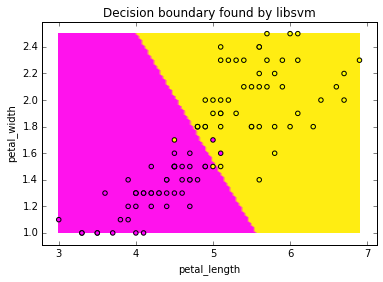

In [123]:
#
# Plot the decision boundary
#

petal_lengths, petal_widths = np.meshgrid(np.linspace(IrisX2F[0,:].min(), IrisX2F[0,:].max(), 100),
                                          np.linspace(IrisX2F[1,:].min(), IrisX2F[1,:].max(), 100))

IrisXGrid = np.vstack([petal_lengths.ravel(), petal_widths.ravel()])
predictions_Grid = svm.predict(IrisXGrid.T)

contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(), cmap='spring')

xlabel('petal_length')
ylabel('petal_width')
title('Decision boundary found by libsvm')

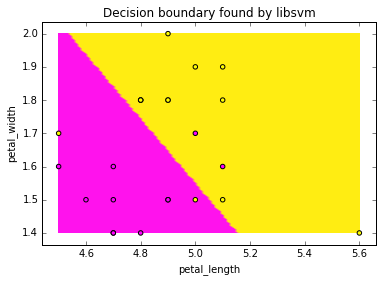

In [140]:
#
# Plot the decision boundary and the support vectors.
#
# You can extract the indices of support vectors and their weights from fields of the 
# svm object. Display the loaction of support vectors and their weights (by changing the 
# size in the scatterplot)
#
# TODO
Xs = IrisX2F.T[svm.support_].T
Ys = IrisY.ravel()[svm.support_]

petal_lengths, petal_widths = np.meshgrid(np.linspace(Xs[0,:].min(), Xs[0,:].max(), 100),
                                          np.linspace(Xs[1,:].min(), Xs[1,:].max(), 100))

IrisXGrid = np.vstack([petal_lengths.ravel(), petal_widths.ravel()])
predictions_Grid = svm.predict(IrisXGrid.T)

contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
scatter(Xs[0,:], Xs[1,:], c=Ys, cmap='spring')

xlabel('petal_length')
ylabel('petal_width')
title('Decision boundary found by libsvm')

The `cvxopt.solvers.qp` solves the following optimization problem: 

\begin{align}
\text{minimize over } x \text{: }& \frac{1}{2} x^T P x + q^T x \\
\text{subject to: } & Gx \leq h \\
& Ax = b
\end{align}

To solve the SVM problem you need to encode the weights $W$, biases $b$, and slack variables $\xi$ as elements of the vector $x$, then properly fill the matrices and vectors $P$, $q$, $G$, $h$. We can ignore setting the $A$ and $b$ parametrs, since there are no linear constraints.

In [14]:
#
# Now solve the SVM using the QP solver
#

n, m = IrisX2F.shape
C=10.0

P = np.zeros((n+1+m, n+1+m)) #w, bias, xi
q = np.zeros((n+1+m,1)) 
G = np.zeros((2*m, n+1+m)) # we have two constrains fot each data point: 
                           # that the margin is equal to 1-xi
                           # and that xi is nonnegative
for i in range(m):
    # margin is equal to 1-xi
    G[2*i]
    # xi is nonnegative
    G[2*i+1][n+1+i] = -1
    
h = np.zeros((2*m,1))
#
# TODO: fill in P, q, G, h
#

#
# Now run the solver
#
ret  = cvxopt.solvers.qp(cvxopt.matrix(P), cvxopt.matrix(q), 
                         cvxopt.matrix(G), cvxopt.matrix(h), )

ret = np.array(ret['x'])

#
# extract the weights and biases
#
W = ret[:n].reshape(-1,1)
b = ret[n]

#
# TODO: Extract the weight and bias from libsvm for comparison
#
# Wlibsvm = 
# blibsvm = 

print 'W', W.T, 'Wlibsvm', Wlibsvm
print 'b', b, 'blibsvm', blibsvm

     pcost       dcost       gap    pres   dres
 0: -8.2045e+03  4.6654e+03  2e+04  2e+01  3e+00
 1:  5.3426e+01 -5.8951e+02  3e+03  2e+00  4e-01
 2:  1.7058e+02 -1.9137e+01  4e+02  3e-01  5e-02
 3:  1.4063e+02  7.5166e+01  1e+02  7e-02  1e-02
 4:  1.3820e+02  9.8722e+01  6e+01  3e-02  5e-03
 5:  1.4016e+02  1.1207e+02  3e+01  4e-03  8e-04
 6:  1.3507e+02  1.1797e+02  2e+01  1e-03  2e-04
 7:  1.2551e+02  1.2356e+02  2e+00  2e-04  3e-05
 8:  1.2445e+02  1.2440e+02  5e-02  4e-06  6e-07
 9:  1.2442e+02  1.2442e+02  1e-03  9e-08  2e-08
10:  1.2442e+02  1.2442e+02  2e-05  1e-09  2e-10
Optimal solution found.
W Shape: (1L, 2L)
[[ 2.75844069  4.82727099]] Wlibsvm Shape: (1L, 2L)
[[ 2.75873306  4.82861713]]
b Shape: (1L,)
[-21.20544719] blibsvm Shape: (1L,)
[-21.20914737]


(1L, 10000L)


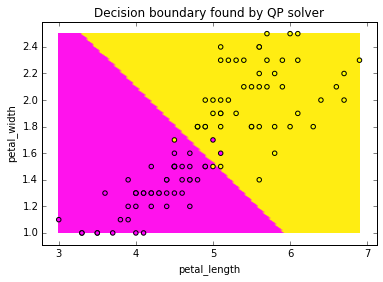

In [15]:
#
# Plot the decision boundary obtained with QP
#

predictions_QP_Grid = (W.T.dot(IrisXGrid) + b)>0.0

print predictions_QP_Grid.shape

contourf(petal_lengths, petal_widths, 
         predictions_QP_Grid.reshape(petal_lengths.shape), cmap='spring')
scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(), cmap='spring')

xlabel('petal_length')
ylabel('petal_width')
title('Decision boundary found by QP solver')

## Problem 3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4583d38350>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f4583ce7690>], dtype=object)

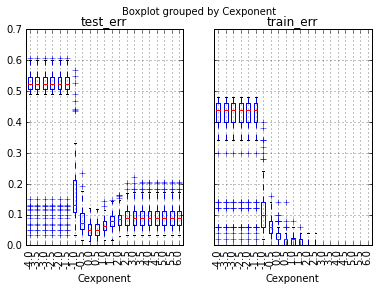

In [11]:
res = []
for rep in xrange(100):
    #
    # TODO: Declare two vectors of indices.
    #
    size = IrisY.size
    bootstrap_sel = floor(rand(size/2) * size).astype(int)
    test_sel = setdiff1d(arange(0., size).astype(int), bootstrap_sel)
    
    bootstrap_IrisX = IrisX[:,bootstrap_sel]
    bootstrap_IrisY = IrisY[:,bootstrap_sel]
    
    test_IrisX = IrisX[:,test_sel]
    test_IrisY = IrisY[:,test_sel]

    #
    # TODO: Loop over a list of exponents.
    #
    for Cexponent in arange(-4., 6.5, .5):
        C = 10.0**Cexponent
        
        #
        # TODO: Train SVM (sklearn/libSVM) with rbf kernel, default gamma and desired C.
        svm = SVC(kernel='rbf',C=C)
        svm.fit(bootstrap_IrisX.T, bootstrap_IrisY.ravel())
        
        #
        # TODO: Retrieve train and test set accuracies.
        train_acc = (svm.predict(bootstrap_IrisX.T)!=bootstrap_IrisY).mean()
        test_acc = (svm.predict(test_IrisX.T)!=test_IrisY).mean()      
        
        res.append(dict(Cexponent=Cexponent, test_err=test_acc, train_err=train_acc))

res = pandas.DataFrame(res)
figure(figsize=(20,10))
res.boxplot(['test_err','train_err'], 'Cexponent', rot=90)